<a href="https://colab.research.google.com/github/surajghuwalewala/CE888_Data_Science_and_Decision_Making/blob/master/Assignment2/CE888_Housing_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
## Kaggle details
import os
os.environ['KAGGLE_USERNAME'] = "surajghuwalewala" # username from the json file
os.environ['KAGGLE_KEY'] = "c14ff4f2803c1ffb349c4b9e1a57020b" # key from the json file

In [0]:
DOWNLOAD_DATA = True

In [3]:
if DOWNLOAD_DATA:
    !kaggle competitions download -c house-prices-advanced-regression-techniques # api copied from kaggle
    #!unzip -q -n '/content/*.zip'  ## unzips all archives  q - quite, n - don't overwrite

data_description.txt: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from tqdm import tqdm_notebook
import random

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import pandas as pd
import numpy as np

train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

In [6]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,...,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,...,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,...,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,G

In [7]:
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,Comp

In [8]:
## Check for Nan values
print("Nan values in Train set is " , train.isnull().sum().sum())
print("Nan values in Test set is " , test.isnull().sum().sum())


Nan values in Train set is  6965
Nan values in Test set is  7000


In [9]:
## Checking for type of data in columns
print("Train set")
train.dtypes.value_counts() 


Train set


object     43
int64      35
float64     3
dtype: int64

In [10]:
print("Test set")
test.dtypes.value_counts() 

Test set


object     43
int64      26
float64    11
dtype: int64

## Imputation

According to data description text, some Nan values have a different meaning.

So imputing accordingly

In [0]:
from sklearn.preprocessing import LabelEncoder


def fillNansAndEncodeLabels(df):

    df["PoolQC"] = df["PoolQC"].fillna("None")
    df["MiscFeature"] = df["MiscFeature"].fillna("None")
    df["Alley"] = df["Alley"].fillna("None")
    df["Fence"] = df["Fence"].fillna("None")
    df["FireplaceQu"] = df["FireplaceQu"].fillna("None")
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'): df[col] = df[col].fillna('None')
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'): df[col] = df[col].fillna(0)
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'): df[col] = df[col].fillna(0)
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'): df[col] = df[col].fillna('None')
    # df["MasVnrType"] = df["MasVnrType"].fillna("None")
    # #df["MasVnrArea"] = df["MasVnrArea"].fillna(0)
    # df["Functional"] = df["Functional"].fillna("Typ")
    # df['MSSubClass'] = df['MSSubClass'].fillna("None")

    for feature in df.columns:
        if (df[feature].dtype == 'object'):
            mode = df[feature].mode()[0]
            temp = df[feature].fillna(mode)
            le = LabelEncoder()
            df[feature] = le.fit_transform(temp)

        else:
            df[feature].fillna(np.mean(df[feature]), inplace=True)


In [0]:
fillNansAndEncodeLabels(train)
fillNansAndEncodeLabels(test)

In [13]:
## Check for Nan
print("Nan values in Train set is " , train.isnull().sum().sum())
print("Nan values in Test set is " , test.isnull().sum().sum())


Nan values in Train set is  0
Nan values in Test set is  0


Checking the dataframes again

In [14]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,1,3,3,0,4,0,5,2,2,0,5,7,5,2003,2003,1,1,12,13,1,196.0,2,4,2,2,4,3,2,706,6,0,150,856,1,...,1,4,856,854,0,1710,1,0,2,1,3,1,2,8,6,0,3,1,2003.0,2,2,548,5,5,2,0,61,0,0,0,0,3,4,1,0,2,2008,8,4,208500
1,2,20,3,80.0,9600,1,1,3,3,0,2,0,24,1,2,0,2,6,8,1976,1976,1,1,8,8,2,0.0,3,4,1,2,4,1,0,978,6,0,284,1262,1,...,1,4,1262,0,0,1262,0,1,2,0,3,1,3,6,6,1,5,1,1976.0,2,2,460,5,5,2,298,0,0,0,0,0,3,4,1,0,5,2007,8,4,181500
2,3,60,3,68.0,11250,1,1,0,3,0,4,0,5,2,2,0,5,7,5,2001,2002,1,1,12,13,1,162.0,2,4,2,2,4,2,2,486,6,0,434,920,1,...,1,4,920,866,0,1786,1,0,2,1,3,1,2,6,6,1,5,1,2001.0,2,2,608,5,5,2,0,42,0,0,0,0,3,4,1,0,9,2008,8,4,223500
3,4,70,3,60.0,9550,1,1,0,3,0,0,0,6,2,2,0,5,7,5,1915,1970,1,1,13,15,2,0.0,3,4,0,4,1,3,0,216,6,0,540,756,1,...,1,4,961,756,0,1717,1,0,1,0,3,1,2,7,6,1,2,5,1998.0,3,3,642,5,5,2,0,35,272,0,0,0,3,4,1,0,2,2006,8,0,140000
4,5,60,3,84.0,14260,1,1,0,3,0,2,0,15,2,2,0,5,8,5,2000,2000,1,1,12,13,1,350.0,2,4,2,2,4,0,2,655,6,0,490,1145,1,...,1,4,1145,1053,0,2198,1,0,2,1,4,1,2,9,6,1,5,1,2000.0,2,3,836,5,5,2,192,84,0,0,0,0,3,4,1,0,12,2008,8,4,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,3,62.0,7917,1,1,3,3,0,4,0,8,2,2,0,5,6,5,1999,2000,1,1,12,13,2,0.0,3,4,2,2,4,3,6,0,6,0,953,953,1,...,1,4,953,694,0,1647,0,0,2,1,3,1,3,7,6,1,5,1,1999.0,2,2,460,5,5,2,0,40,0,0,0,0,3,4,1,0,8,2007,8,4,175000
1456,1457,20,3,85.0,13175,1,1,3,3,0,4,0,14,2,2,0,2,6,6,1978,1988,1,1,9,10,3,119.0,3,4,1,2,4,3,0,790,5,163,589,1542,1,...,1,4,2073,0,0,2073,1,0,2,0,3,1,3,7,2,2,5,1,1978.0,3,2,500,5,5,2,349,0,0,0,0,0,3,2,1,0,2,2010,8,4,210000
1457,1458,70,3,66.0,9042,1,1,3,3,0,4,0,6,2,2,0,5,7,9,1941,2006,1,1,5,5,2,0.0,0,2,4,4,1,3,2,275,6,0,877,1152,1,...,1,4,1188,1152,0,2340,0,0,2,0,4,1,2,9,6,2,2,1,1941.0,2,1,252,5,5,2,0,60,0,0,0,0,3,0,3,2500,5,2010,8,4,266500
1458,1459,20,3,68.0,9717,1,1,3,3,0,4,0,12,2,2,0,2,5,6,1950,1996,3,1,8,8,2,0.0,3,4,1,4,4,2,2,49,5,1029,0,1078,1,...,1,0,1078,0,0,1078,1,0,1,0,2,1,2,5,6,0,3,1,1950.0,3,1,240,5,5,2,366,0,112,0,0,0,3,4,1,0,4,2010,8,4,142125


In [15]:
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,2,80.0,11622,1,1,3,3,0,4,0,12,1,2,0,2,5,6,1961,1961,1,0,10,12,2,0.0,3,4,1,4,4,3,5,468.0,3,144.0,270.0,882.0,0,4,1,3,896,0,0,896,0.0,0.0,1,0,2,1,3,5,6,0,3,1,1961.0,3,1.0,730.0,4,5,2,140,0,0,0,120,0,2,2,1,0,6,2010,8,4
1,1462,20,3,81.0,14267,1,1,0,3,0,0,0,12,2,2,0,2,6,6,1958,1958,3,0,11,13,1,108.0,3,4,1,4,4,3,0,923.0,6,0.0,406.0,1329.0,0,4,1,3,1329,0,0,1329,0.0,0.0,1,1,3,1,2,6,6,0,3,1,1958.0,3,1.0,312.0,4,5,2,393,36,0,0,0,0,2,4,0,12500,6,2010,8,4
2,1463,60,3,74.0,13830,1,1,0,3,0,4,0,8,2,2,0,4,5,5,1997,1998,1,0,10,12,2,0.0,3,4,2,2,4,3,2,791.0,6,0.0,137.0,928.0,0,2,1,3,928,701,0,1629,0.0,0.0,2,1,3,1,3,6,6,1,5,1,1997.0,0,2.0,482.0,4,5,2,212,34,0,0,0,0,2,2,1,0,3,2010,8,4
3,1464,60,3,78.0,9978,1,1,0,3,0,4,0,8,2,2,0,4,6,6,1998,1998,1,0,10,12,1,20.0,3,4,2,4,4,3,2,602.0,6,0.0,324.0,926.0,0,0,1,3,926,678,0,1604,0.0,0.0,2,1,3,1,2,7,6,1,2,1,1998.0,0,2.0,470.0,4,5,2,360,36,0,0,0,0,2,4,1,0,6,2010,8,4
4,1465,120,3,43.0,5005,1,1,0,1,0,4,0,22,2,2,4,2,8,5,1992,1992,1,0,6,6,2,0.0,2,4,2,2,4,3,0,263.0,6,0.0,1017.0,1280.0,0,0,1,3,1280,0,0,1280,0.0,0.0,2,0,2,1,2,5,6,0,3,1,1992.0,2,2.0,506.0,4,5,2,0,82,0,0,144,0,2,4,1,0,1,2010,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,4,21.0,1936,1,1,3,3,0,4,0,10,2,2,3,4,4,7,1970,1970,1,0,5,5,2,0.0,3,4,1,4,4,3,6,0.0,6,0.0,546.0,546.0,0,2,1,3,546,546,0,1092,0.0,0.0,1,1,3,1,3,5,6,0,3,6,0.0,1,0.0,0.0,2,3,2,0,0,0,0,0,0,2,4,1,0,6,2006,8,4
1455,2916,160,4,21.0,1894,1,1,3,3,0,4,0,10,2,2,4,4,4,5,1970,1970,1,0,5,5,2,0.0,3,4,1,4,4,3,5,252.0,6,0.0,294.0,546.0,0,4,1,3,546,546,0,1092,0.0,0.0,1,1,3,1,3,6,6,0,3,4,1970.0,3,1.0,286.0,4,5,2,0,24,0,0,0,0,2,4,1,0,4,2006,8,0
1456,2917,20,3,160.0,20000,1,1,3,3,0,4,0,11,2,2,0,2,5,7,1960,1996,1,0,10,12,2,0.0,3,4,1,4,4,3,0,1224.0,6,0.0,0.0,1224.0,0,0,1,3,1224,0,0,1224,1.0,0.0,1,0,4,1,3,7,6,1,5,5,1960.0,3,2.0,576.0,4,5,2,474,0,0,0,0,0,2,4,1,0,9,2006,8,0
1457,2918,85,3,62.0,10441,1,1,3,3,0,4,0,11,2,2,0,5,5,5,1992,1992,1,0,6,14,2,0.0,3,4,2,2,4,0,2,337.0,6,0.0,575.0,912.0,0,4,1,3,970,0,0,970,0.0,1.0,1,0,3,1,3,6,6,0,3,6,0.0,1,0.0,0.0,2,3,2,80,32,0,0,0,0,2,2,3,700,7,2006,8,4


Checking for covariate shift

In [0]:
# create dummy dataframes for CS detection
cov_train = train.drop(columns=['Id','SalePrice'])
cov_test = test.drop(columns=['Id'])

In [0]:
def plot_train_test_feature(train, test, subplot_size=(5,5)):
    
    ## Selecting random columns for plotting
    feature_list = cov_train.sample(subplot_size[0]*subplot_size[1],random_state=1010, axis=1).columns


    plt.figure()
    fig, ax = plt.subplots(subplot_size[0],subplot_size[1],figsize=(18,22))
    
    for i in range(len(feature_list)):
        plt.subplot(subplot_size[0],subplot_size[1],i+1)
        sns.distplot(train[feature_list[i]], hist=False, label='Train')
        sns.distplot(test[feature_list[i]], hist=False, label='Test')
        plt.xlabel(feature_list[i], fontsize=9)
    plt.show()


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

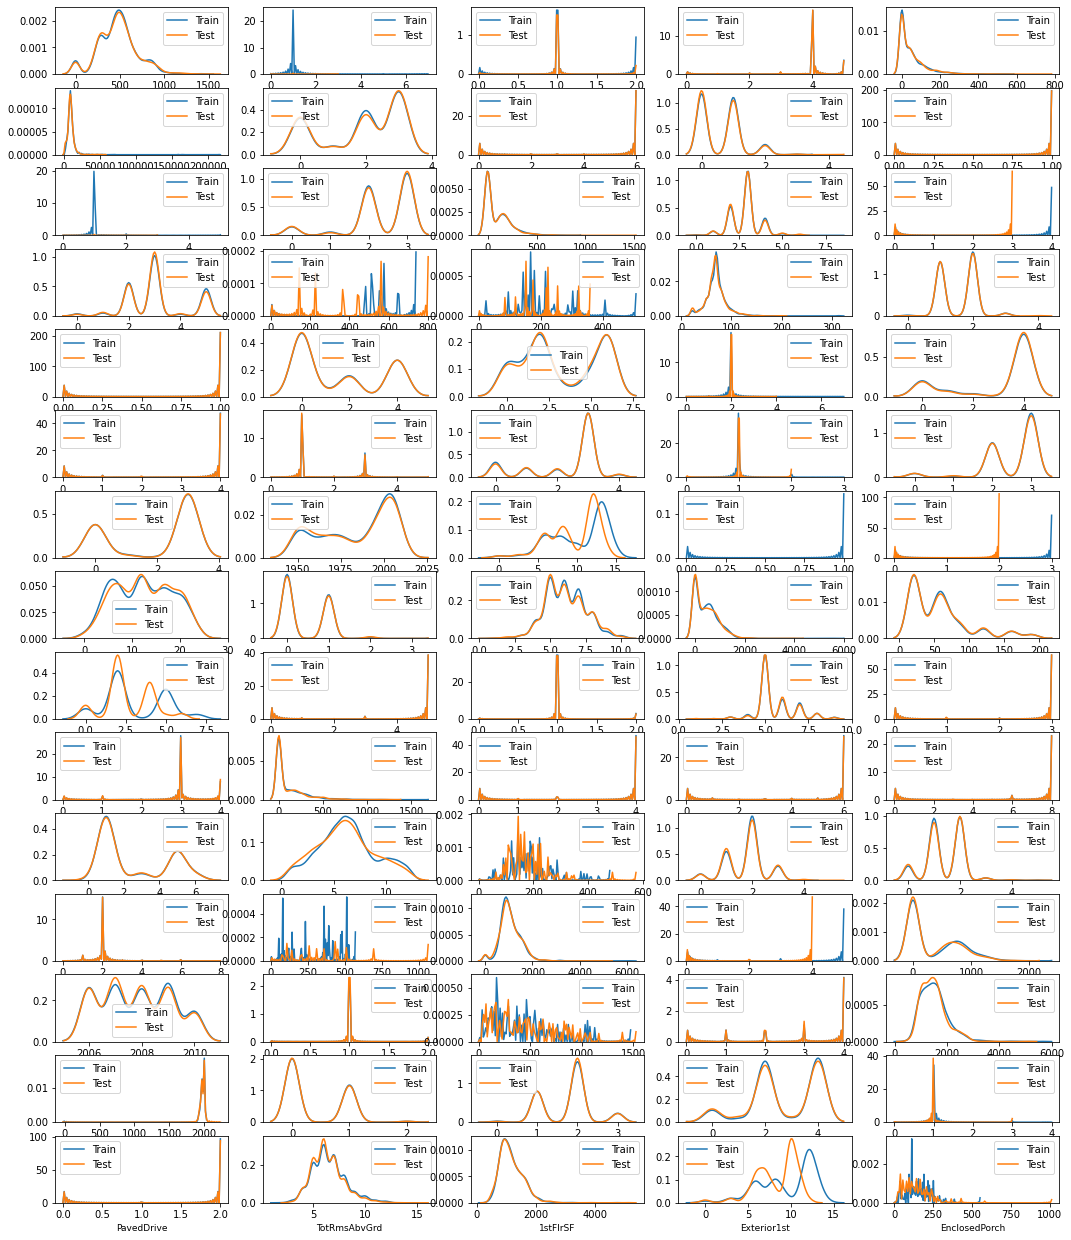

In [18]:
plot_train_test_feature(cov_train, cov_test, subplot_size=(15,5))

Seevral features here seem to have covariate shift

In [0]:
def detectCovariatelyShiftedFeatures(train, test, cv = 10, thresh = 0.7, n_samples = None):
    
    #labels for train and test set
    train['set'] = 0
    test['set'] = 1

    ## Consider taking smaller sample in case of huge datasets
    if n_samples is not None:
        print("Taking {} random samples from the data".format(n_samples))
        train = train.sample(n_samples, random_state=102)
        test = test.sample(n_samples, random_state=102)


    combinedData = train.append(test)
    X = combinedData.drop(columns=['set'], axis=1)
    y = combinedData['set']

    model = RandomForestClassifier(n_estimators = 50, max_depth = 5, min_samples_leaf = 5)
    CS_features = []

    for feature in tqdm_notebook(X.columns):
        score = cross_val_score(model, pd.DataFrame(X[feature]), y, cv=cv, scoring='roc_auc')
        if np.mean(score) > thresh:
            CS_features.append(feature)
            print(feature,np.mean(score))

    return CS_features


In [20]:
cs_features = detectCovariatelyShiftedFeatures(cov_train, cov_test, cv = 10, thresh = 0.7,)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


HouseStyle 0.7397034120395235
RoofMatl 0.9955196679198401
Exterior1st 0.9162035964566039
Exterior2nd 0.8096549135828033
Heating 0.9964720203699988
Electrical 0.9962556700163709
GarageQual 0.9983688471020635
PoolQC 0.9989655657721899



In [0]:
from sklearn.model_selection import StratifiedKFold as SKF
from sklearn.metrics import roc_auc_score as AUC
from sklearn.svm import SVC

def getTrainWeights(train, test):
    #labels for train and test set
    train['set'] = 0
    test['set'] = 1

    combinedData = train.append(test)
    X = combinedData.drop(columns=['set'], axis=1)
    y = combinedData['set']

    clf = RandomForestClassifier()
    # clf = SVC(probability=True)
    predictions = np.zeros(y.shape)
    skf = SKF(n_splits=10, shuffle=True, random_state=888)

    for kfold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print('Training discriminator model for fold {}'.format(kfold))
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            
        clf.fit(X_train, y_train)
        probs = clf.predict_proba(X_test)[:, 1]
        predictions[test_idx] = probs

    # Selecting the train part
    # train_preds = predictions[:len(train)]
    # weights = (1./train_preds) - 1. 
    # weights /= np.mean(weights) # we do this to re-normalize the computed log-loss

    all_weights = np.exp(predictions)*len(train)/len(test)
    tr_weights = all_weights[:len(train)]

    return tr_weights

##REF: https://github.com/ayeright/covariate-shift-adaptation/blob/master/covariate_shift_adaption/importance_estimation.py#L200

In [22]:
train_weights = getTrainWeights(cov_train, cov_test)

Training discriminator model for fold 0
Training discriminator model for fold 1
Training discriminator model for fold 2
Training discriminator model for fold 3
Training discriminator model for fold 4
Training discriminator model for fold 5
Training discriminator model for fold 6
Training discriminator model for fold 7
Training discriminator model for fold 8
Training discriminator model for fold 9


In [23]:
cov_train.shape, cov_test.shape, np.shape(train_weights)

((1460, 80), (1459, 80), (1460,))

## Training without consider weights

In [0]:
 from sklearn.ensemble import GradientBoostingRegressor as GBR
 from sklearn.model_selection import GridSearchCV
 from sklearn.metrics import  make_scorer
 from sklearn.metrics import mean_squared_error
 from sklearn.linear_model import SGDRegressor as SGD

In [0]:
y = train['SalePrice']
X = train.drop(['SalePrice'], axis=1)

In [0]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(X,y,test_size=0.2,random_state=424)

In [0]:
params = {'loss' : ['ls', 'lad', 'huber', 'quantile'], 'n_estimators' : np.arange(50,200,50) }
# params = {'loss' : ['squared_loss', 'epsilon_insensitive', 'huber', 'squared_epsilon_insensitive'], 'learning_rate':['optimal', 'invscaling']}

In [0]:
regr = GridSearchCV(GBR(), param_grid=params,scoring='neg_mean_squared_error', n_jobs=-1, cv=10)

In [29]:
# regr.fit(train_X,train_y)
regr.fit(X,y)

GridSearchCV(cv=10, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                

In [0]:
predictions = regr.predict(test)
# predictions = regr.predict(val_X)

In [0]:
# rmse = mean_squared_error(np.log(val_y), np.log(predictions), squared=False)
# print(rmse)

In [0]:
# predictions = regr.predict(test)
# 

In [0]:
# predictions

## Training with weights|

In [0]:
def score_f(y_true, y_pred, sample_weight):
    return mean_squared_error(y_true.values, y_pred,
        sample_weight=sample_weight.loc[y_true.index.values].values.reshape(-1))

score_params = {"sample_weight": pd.DataFrame(train_weights)}
my_scorer = make_scorer(score_f,
                        greater_is_better=False, 
                        # needs_proba=True, 
                        needs_threshold=False,
                        **score_params)

### REF: https://stackoverflow.com/questions/49581104/sklearn-gridsearchcv-not-using-sample-weight-in-score-function
### for using weights with GridSearchCV                        

In [0]:
params = {'loss' : ['ls', 'lad', 'huber', 'quantile'], 'n_estimators' : np.arange(50,200,50) }

# params = {'loss' : ['squared_loss', 'epsilon_insensitive', 'huber', 'squared_epsilon_insensitive'], 'learning_rate':['optimal', 'invscaling']}

In [0]:
cs_regr = GridSearchCV(GBR(), param_grid=params,scoring=my_scorer, n_jobs=-1, cv=10)


In [37]:
cs_regr.fit(X,y)
# cs_regr.fit(train_X,train_y)

GridSearchCV(cv=10, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_...
             param_grid={'lo

In [0]:
cs_preds = cs_regr.predict(test)
# cs_preds = cs_regr.predict(val_X)

In [0]:
# rmse = mean_squared_error(np.log(val_y), np.log(cs_preds), squared=False)
# print(rmse)

## Val test

## Submissions

### Without CS adaptation

In [0]:
sub_df = pd.DataFrame({'id':test['Id']})

In [0]:
sub_df['SalePrice'] = predictions

In [42]:
sub_df

,id,SalePrice
0,1461,125013.068221
1,1462,161171.241700
2,1463,178523.579351
3,1464,182867.906546
4,1465,210879.778671
...,...,...
1454,2915,101400.131876
1455,2916,105797.043492
1456,2917,161131.042874
1457,2918,118596.094710


In [0]:
sub_df.to_csv("submission_no_cs.csv", index=False)


In [50]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f /content/submission_no_cs.csv -m "8th submission with CS"

100% 33.7k/33.7k [00:04<00:00, 8.36kB/s]
Successfully submitted to House Prices: Advanced Regression Techniques

### With CS adaptation

In [0]:
sub_df = pd.DataFrame({'id':test['Id']})
sub_df['SalePrice'] = cs_preds

In [46]:
sub_df

,id,SalePrice
0,1461,123302.919670
1,1462,160878.575909
2,1463,178413.178610
3,1464,183126.386406
4,1465,197302.509210
...,...,...
1454,2915,89972.983232
1455,2916,93999.714731
1456,2917,159698.059920
1457,2918,118458.529599


In [0]:
sub_df.to_csv("submission_cs_adap.csv", index=False)

In [52]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f /content/submission_cs_adap.csv -m "8th submission without CS"

100% 33.7k/33.7k [00:03<00:00, 10.1kB/s]
Successfully submitted to House Prices: Advanced Regression Techniques

In [53]:
!kaggle competitions submissions -c house-prices-advanced-regression-techniques

fileName                date                 description                   status    publicScore  privateScore  
----------------------  -------------------  ----------------------------  --------  -----------  ------------  
submission_cs_adap.csv  2020-04-12 17:26:06  8th submission without CS     complete  0.14370      None          
submission_no_cs.csv    2020-04-12 17:25:48  8th submission with CS        complete  0.16349      None          
submission_cs_adap.csv  2020-04-12 17:00:44  7th submission without CS     complete  0.15844      None          
submission_no_cs.csv    2020-04-12 17:00:12  7th submission with CS        complete  0.15892      None          
submission_cs_adap.csv  2020-04-11 10:21:53  6th submission without CS     complete  0.15864      None          
submission_no_cs.csv    2020-04-11 10:21:21  6th submission with CS        complete  0.14404      None          
submission_cs_adap.csv  2020-04-10 20:06:56  5th submission without CS     complete  0.14610    